# Retrieval

## Traditional RAG System Workflow
In a traditional RAG (Retrieval-Augmented Generation) system, the basic process consists of:

### Retrieval: Retrieve candidate documents from the database that are relevant to the user's query.
### Generation: Generate an answer based on the retrieved documents and the query.
### Output: Provide the final generated response.

![Routing](../resources/RAG/6_rag_retrieval_1.png)

## Improving the Accuracy of RAG Systems
To enhance the accuracy of a RAG system, we can introduce the following optimizations:

### Ranking: After retrieving an initial set of candidate documents, re-rank them through further evaluation to improve relevance and generation quality.

### Refinement: Perform more detailed filtering and optimization during the document retrieval phase to ensure that the documents used for generation are highly accurate. The goal is to refine retrieval results and enhance the quality of generated content before the generation step.

## Re-Ranking
### Re-Ranking: Enhancing Document Ordering in Retrieval
Re-Ranking refers to the process of reordering retrieved candidate documents. This step is crucial for improving the quality of the generation model, ensuring that the generated answers or content are more relevant and accurate.

### Common Re-Ranking Methods:
#### Similarity-Based Ranking

Uses similarity measurement techniques between queries and documents, such as cosine similarity or dot product.

#### Deep Learning-Based Ranking Models

More advanced re-ranking methods leverage deep learning models, such as BERT or T5, to further evaluate the relevance between candidate documents and the query.

#### Regression Model-Based Ranking
In some cases, candidate document features (such as length, similarity, title, etc.) can be input into a regression model.
The model predicts an importance score for each document.
The documents are then ranked based on their predicted scores to improve retrieval relevance.

In [1]:
from langchain_community.llms import Ollama
from dbUtils import DBUtils

dbUtils = DBUtils()
# Initialize Ollama LLM with qwen model
llm = Ollama(
    model="qwen2.5:latest",
    temperature=0.7,
    top_k=10,
    top_p=0.95,
    repeat_penalty=1.1,
    num_ctx=4096
)

embedding_model = dbUtils.get_embedding_function("ollama")

/var/folders/qj/xprrbhtn049_4mqqdmkglrqh0000gp/T/ipykernel_98653/2936185485.py:6: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(


In [2]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("../data/BeigeBook_20250115.pdf")
    
    # Load all pages
ages = loader.load()

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

summaries = chain.batch(ages, {"max_concurrency": 5})

In [3]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="retrieval",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

vectorstore = QdrantVectorStore(
    client=client,
    collection_name="retrieval",
    embedding=embedding_model,
)

retriever = vectorstore.as_retriever(k=4)

In [4]:
import uuid
from langchain_core.documents import Document
from langchain.storage import InMemoryByteStore
from langchain.retrievers.multi_vector import MultiVectorRetriever


# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in summaries]


# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, summary_docs)))

# Refinement

**Self-reflection RAG** is a relatively new concept, typically referring to the integration of self-reflection mechanisms within RAG systems to improve generation outcomes. This process involves incorporating self-assessment during the generation steps, aiding models in better understanding and correcting previous generation results to enhance the final output quality.


## CRAG

**CRAG (Corrective Retrieval Augmented Generation)** is a strategy designed for RAG, applying self-reflection/self-scoring mechanisms to retrieved documents.

- If the document is correct:
  - Refine the document's knowledge, removing irrelevant parts related to the user query.

- If the document is ambiguous:
  - Refine the document's knowledge, removing irrelevant parts related to the user query.
  - Conduct a web search for relevant knowledge.

- If the document is incorrect:
  - Conduct a web search for relevant knowledge.

![CRAG](../resources/RAG/6_rag_retrieval_2.png)

### Retrieval Grader

In [5]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)


retrieval_grader = prompt | llm | JsonOutputParser()
question = "Economy Status of the United States"
docs = retriever.invoke(question)
print(docs)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

[Document(metadata={'doc_id': '72c55b86-c7aa-4e99-a439-5e2ba68c5184'}, page_content="The document summarizes economic activity in the Seventh District of the United States as reported by the Federal Reserve Bank of Chicago. Over the recent reporting period, economic conditions increased slightly overall, with modest gains in consumer spending and employment. Construction and real estate remained stable, while manufacturing and business spending showed a slight decrease. Prices and wages also rose moderately, and financial conditions improved somewhat.\n\nIn labor markets, employment increased slightly and is expected to continue growing at a similar pace over the next year. However, there are mixed signals regarding the job market's health; some companies reported difficulty in finding higher-skilled workers, while others noted that it was easier to source labor recently due to nearby competitors reducing their workforce. Wages continued to rise moderately, with an increase in health i

### Generate

In [6]:
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

The United States economy experienced moderate growth across various sectors with some challenges, particularly in labor markets and price increases. Key sectors showed mixed results, with slight gains in employment and consumer spending but also a decrease in manufacturing and business spending. Overall, the economy is expected to continue growing positively but cautiously due to potential policy changes.


### Search

In [7]:
import os
from dotenv import load_dotenv
from openai import OpenAI
load_dotenv()

DEEPSEEK_API_KEY = os.getenv('DEEPSEEK_API_KEY')

In [8]:


client = OpenAI(api_key=os.getenv('DEEPSEEK_API_KEY'), base_url="https://api.deepseek.com")  

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "What's the capital of United States ?"}
    ],
    temperature=0.7
)

print(response.choices[0].message.content)

The capital of the United States is **Washington, D.C.** (District of Columbia). It serves as the seat of the federal government and is home to important landmarks such as the White House, the Capitol, and the Supreme Court.


### Create the Graph

In [9]:
! pip install typing IPython langchain langgraph

In [10]:
from typing import List, TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph

In [11]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]

In [12]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    print("retrieve documents")
    print(documents)
    steps = state["steps"]
    print(steps)
    steps.append("retrieve_documents")
    
    return {"documents": documents, "question": question, "steps": steps}

In [13]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }

In [14]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        print(score)
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    print(filtered_docs)
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }

In [15]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_search_tool = OpenAI(api_key=os.getenv('DEEPSEEK_API_KEY'), base_url="https://api.deepseek.com")  

    response = web_search_tool.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": question}
        ],
        temperature=0.7
    )
    web_results = []
    web_results.append(response.choices[0].message.content)

    # web_results = [{"content": response.choices[0].message.content}]

    print(web_results)

    
    documents.extend(
        [
            Document(page_content=d)
            for d in web_results
        ]
    )
    
    return {"documents": documents, "question": question, "steps": steps}

In [16]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

![Corrective RAG](../resources/RAG/6_rag_retrieval_3.png)

In [17]:
# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [ ]:
import uuid

def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": question}
response = predict_custom_agent_local_answer(example)
response

retrieve documents
[Document(metadata={'doc_id': '23a4c27b-5da6-497d-b650-1bea2d48af2e'}, page_content='The document provides an overview of economic conditions across various sectors in the United States. In the manufacturing sector, there is a mixed outlook; demand has strengthened for capital equipment due to automation investments aimed at cost savings, particularly as labor costs are elevated. Meanwhile, there has been no change in the demand for lumber products. The Pacific Northwest experienced some general slowdowns, but defense manufacturing showed signs of growth.\n\nIn agriculture and resource-related industries, conditions have softened slightly. Demand remained stable for agricultural products like fruits, vegetables, meat, and dairy, though food crop yields were lower than those from previous harvests due to drought in the Mountain West. Almond exports decreased while log harvesting slowed seasonally, causing log prices to rise. Log exports are also constrained by low dem

{'response': 'The U.S. economy showed mixed trends across various sectors, with some positive indicators in consumer behavior and holiday sales but also facing challenges like labor costs being elevated and certain manufacturing activities slowing down. Retail sales grew robustly, while commercial real estate saw mixed conditions. Overall, the outlook is cautiously optimistic but tempered by concerns about potential policy changes.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'generate_answer']}

# Self-RAG

### Retrieval Grader

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_community.llms import Ollama
from langchain_core.output_parsers import JsonOutputParser
from dbUtils import DBUtils
from langchain_deepseek import ChatDeepSeek

dbUtils = DBUtils()


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# embedding_model = dbUtils.get_embedding_function("ollama")

output_parser = JsonOutputParser(pydantic_object=GradeDocuments)



# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

# retrieval_grader = grade_prompt | llm | output_parser

In [ ]:
question = "Economy Status of the United States"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### Generate

In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")



# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/Users/easonyin/miniconda3/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


The U.S. economy shows mixed conditions across sectors. Manufacturing has seen modest growth, particularly in automation and electronics, while retail sales and nonfinancial services continue to expand. However, challenges like high financing costs in real estate, sluggish demand in some regions, and concerns over policy changes temper the overall outlook.


### Hallucination Grader

In [ ]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call


# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeDocuments(binary_score='yes')

### Answer Grader

In [ ]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeDocuments(binary_score='yes')

### Question Re-writer

In [ ]:

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is the current economic status of the United States, including key indicators such as GDP growth, unemployment rate, inflation, and fiscal policies?'

### Create Graph
#### Graph State

In [ ]:
from typing import List, TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

#### Nodes

In [ ]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

#### Edges

In [ ]:
from pprint import pprint

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

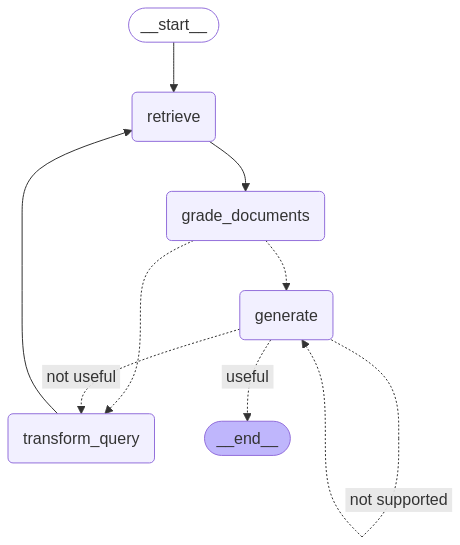

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
inputs = {"question": "What are the types of agent memory?"}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---


/var/folders/qj/xprrbhtn049_4mqqdmkglrqh0000gp/T/ipykernel_5249/2369591656.py:15: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  documents = retriever.get_relevant_documents(question)


"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---G

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT